In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir("/content/drive/MyDrive/GSET25")
!pwd

/content/drive/MyDrive/GSET25


In [3]:
!pip install monai-generative
!pip install lpips
!pip install medmnist

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2/176.2 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=ed32900dd0f0956861fdf8519bf9422995f23deddc9dbf1d3ae6623cf4f4f374
  Stored in directory: /root/.cache/pip/wheels/19/39/2f/2d3cadc408a8804103f1c34ddd4b9f6a93497b11fa96fe738e
Successfully built fire


In [ ]:
import numpy as np
from medmnist import BreastMNIST,  BloodMNIST
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
from torchvision.transforms import Compose, ToTensor



class MyMedMNIST( BloodMNIST):
    def __getitem__(self, item):
        img, _ = super().__getitem__(item)
        return img

if __name__ == '__main__':
    image_size = 64
    train_data = MyMedMNIST(split="train", download=True, size=image_size, root="/content/drive/MyDrive/GSET25", transform=ToTensor())
    print(len(train_data))
    indices = list(range(4000))
    train_data = Subset(train_data, indices)
    print(len(train_data))

    val_data = MyMedMNIST(split="val", download=True, size=image_size, root="/content/drive/MyDrive/GSET25", transform=ToTensor())
    print(len(val_data))
    val_data = Subset(val_data, list(range(1000)))
    print(len(val_data))

    train_loader = DataLoader(
        dataset=train_data,
        batch_size=128,
        num_workers=2,
        shuffle=True,
        drop_last=False
    )
    val_loader = DataLoader(
        dataset=val_data,
        batch_size=128,
        num_workers=2,
        shuffle=True,
        drop_last=False
    )

Using downloaded and verified file: /content/drive/MyDrive/GSET25/bloodmnist_64.npz
11959
4000
Using downloaded and verified file: /content/drive/MyDrive/GSET25/bloodmnist_64.npz
1712
1000


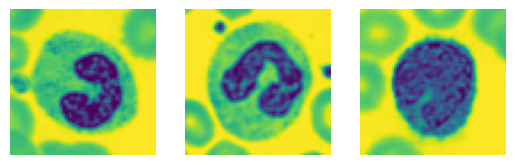

In [ ]:
check_data = next(iter((train_loader)))
fig, ax = plt.subplots(nrows=1, ncols=3)
for image_n in range(3):
    ax[image_n].imshow(check_data[image_n, 0, :, :])
    ax[image_n].axis("off")

In [4]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from monai import transforms
from monai.apps import MedNISTDataset
from monai.config import print_config
from monai.data import DataLoader, Dataset
from monai.utils import first, set_determinism
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm

from generative.inferers import LatentDiffusionInferer
from generative.losses.adversarial_loss import PatchAdversarialLoss
from generative.losses.perceptual import PerceptualLoss
from generative.networks.nets import AutoencoderKL, DiffusionModelUNet, PatchDiscriminator
from generative.networks.schedulers import DDPMScheduler

/usr/local/lib/python3.10/dist-packages/generative/networks/layers/vector_quantizer.py:86: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)
/usr/local/lib/python3.10/dist-packages/generative/networks/layers/vector_quantizer.py:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)


In [5]:
set_determinism(42)
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmpl1a2vmk4


In [6]:
train_data = MedNISTDataset(root_dir=root_dir, section="training", download=True, seed=0)
train_datalist = [{"image": item["image"]} for item in train_data.data if item["class_name"] == "Hand"]
image_size = 64
train_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
        transforms.RandAffined(
            keys=["image"],
            rotate_range=[(-np.pi / 36, np.pi / 36), (-np.pi / 36, np.pi / 36)],
            translate_range=[(-1, 1), (-1, 1)],
            scale_range=[(-0.05, 0.05), (-0.05, 0.05)],
            spatial_size=[image_size, image_size],
            padding_mode="zeros",
            prob=0.5,
        ),
    ]
)
train_ds = Dataset(data=train_datalist, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=4, persistent_workers=True)

val_data = MedNISTDataset(root_dir=root_dir, section="validation", download=True, seed=0)
val_datalist = [{"image": item["image"]} for item in val_data.data if item["class_name"] == "Hand"]
val_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
    ]
)
val_ds = Dataset(data=val_datalist, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=True, num_workers=4, persistent_workers=True)

MedNIST.tar.gz: 59.0MB [00:01, 39.6MB/s]                            

2024-12-20 10:34:26,759 - INFO - Downloaded: /tmp/tmpl1a2vmk4/MedNIST.tar.gz


2024-12-20 10:34:27,187 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2024-12-20 10:34:27,191 - INFO - Writing into directory: /tmp/tmpl1a2vmk4.


Loading dataset: 100%|██████████| 47164/47164 [00:38<00:00, 1223.58it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


2024-12-20 10:35:29,296 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2024-12-20 10:35:29,297 - INFO - File exists: /tmp/tmpl1a2vmk4/MedNIST.tar.gz, skipped downloading.
2024-12-20 10:35:29,299 - INFO - Non-empty folder exists in /tmp/tmpl1a2vmk4/MedNIST, skipped extracting.


Loading dataset: 100%|██████████| 5895/5895 [00:04<00:00, 1338.69it/s]


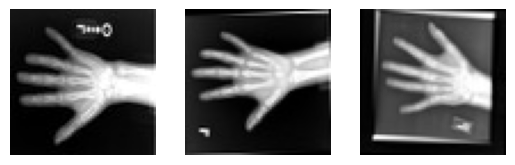

In [8]:
check_data = first(train_loader)
fig, ax = plt.subplots(nrows=1, ncols=3)
for image_n in range(3):
    ax[image_n].imshow(check_data["image"][image_n, 0, :, :], cmap="gray")
    ax[image_n].axis("off")

In [16]:
device = torch.device("cuda")
autoencoderkl = AutoencoderKL(
    spatial_dims=2,
    in_channels=1,  # Change in_channels to 3 to match the input data
    out_channels=1,
    num_channels=(128, 128, 256),
    latent_channels=3,
    num_res_blocks=2,
    attention_levels=(False, False, False),
    with_encoder_nonlocal_attn=False,
    with_decoder_nonlocal_attn=False,
)
autoencoderkl = autoencoderkl.to(device)

In [17]:
perceptual_loss = PerceptualLoss(spatial_dims=2, network_type="alex")
perceptual_loss.to(device)
perceptual_weight = 0.001

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted

In [18]:
discriminator = PatchDiscriminator(spatial_dims=2, num_layers_d=3, num_channels=64, in_channels=1, out_channels=1)
discriminator = discriminator.to(device)

adv_loss = PatchAdversarialLoss(criterion="least_squares")
adv_weight = 0.01

In [19]:
optimizer_g = torch.optim.Adam(autoencoderkl.parameters(), lr=1e-4)
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=5e-4)

# For mixed precision training
scaler_g = torch.cuda.amp.GradScaler()
scaler_d = torch.cuda.amp.GradScaler()

<ipython-input-19-a3c26ff30d0e>:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_g = torch.cuda.amp.GradScaler()
<ipython-input-19-a3c26ff30d0e>:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_d = torch.cuda.amp.GradScaler()


In [20]:
import time

In [21]:
kl_weight = 1e-6
n_epochs = 100
val_interval = 10
autoencoder_warm_up_n_epochs = 10

epoch_recon_losses = []
epoch_gen_losses = []
epoch_disc_losses = []
val_recon_losses = []
intermediary_images = []
num_example_images = 4
start_time = time.time()
for epoch in range(n_epochs):
    autoencoderkl.train()
    discriminator.train()
    epoch_loss = 0
    gen_epoch_loss = 0
    disc_epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=110)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        images = batch["image"].to(device)
        optimizer_g.zero_grad(set_to_none=True)

        with autocast(enabled=True):
            reconstruction, z_mu, z_sigma = autoencoderkl(images)

            recons_loss = F.l1_loss(reconstruction.float(), images.float())
            p_loss = perceptual_loss(reconstruction.float(), images.float())
            kl_loss = 0.5 * torch.sum(z_mu.pow(2) + z_sigma.pow(2) - torch.log(z_sigma.pow(2)) - 1, dim=[1, 2, 3])
            kl_loss = torch.sum(kl_loss) / kl_loss.shape[0]
            loss_g = recons_loss + (kl_weight * kl_loss) + (perceptual_weight * p_loss)

            if epoch > autoencoder_warm_up_n_epochs:
                logits_fake = discriminator(reconstruction.contiguous().float())[-1]
                generator_loss = adv_loss(logits_fake, target_is_real=True, for_discriminator=False)
                loss_g += adv_weight * generator_loss

        scaler_g.scale(loss_g).backward()
        scaler_g.step(optimizer_g)
        scaler_g.update()

        if epoch > autoencoder_warm_up_n_epochs:
            with autocast(enabled=True):
                optimizer_d.zero_grad(set_to_none=True)

                logits_fake = discriminator(reconstruction.contiguous().detach())[-1]
                loss_d_fake = adv_loss(logits_fake, target_is_real=False, for_discriminator=True)
                logits_real = discriminator(images.contiguous().detach())[-1]
                loss_d_real = adv_loss(logits_real, target_is_real=True, for_discriminator=True)
                discriminator_loss = (loss_d_fake + loss_d_real) * 0.5

                loss_d = adv_weight * discriminator_loss

            scaler_d.scale(loss_d).backward()
            scaler_d.step(optimizer_d)
            scaler_d.update()

        epoch_loss += recons_loss.item()
        if epoch > autoencoder_warm_up_n_epochs:
            gen_epoch_loss += generator_loss.item()
            disc_epoch_loss += discriminator_loss.item()

        progress_bar.set_postfix(
            {
                "recons_loss": epoch_loss / (step + 1),
                "gen_loss": gen_epoch_loss / (step + 1),
                "disc_loss": disc_epoch_loss / (step + 1),
            }
        )
    epoch_recon_losses.append(epoch_loss / (step + 1))
    epoch_gen_losses.append(gen_epoch_loss / (step + 1))
    epoch_disc_losses.append(disc_epoch_loss / (step + 1))

    if (epoch + 1) % val_interval == 0:
        autoencoderkl.eval()
        val_loss = 0
        with torch.no_grad():
            for val_step, batch in enumerate(val_loader, start=1):
                images = batch["image"].to(device)

                with autocast(enabled=True):
                    reconstruction, z_mu, z_sigma = autoencoderkl(images)
                    # Get the first reconstruction from the first validation batch for visualisation purposes
                    if val_step == 1:
                        intermediary_images.append(reconstruction[:num_example_images, 0])

                    recons_loss = F.l1_loss(images.float(), reconstruction.float())

                val_loss += recons_loss.item()

        val_loss /= val_step
        val_recon_losses.append(val_loss)
        print(f"epoch {epoch + 1} val loss: {val_loss:.4f}")
progress_bar.close()
del discriminator
del perceptual_loss
torch.cuda.empty_cache()
elapsed_time = time.time() - start_time
print(f"Total training time: {elapsed_time:.2f} seconds")

Epoch 0:   0%|                                                                        | 0/125 [00:00<?, ?it/s]<ipython-input-21-0e9e74a81b4e>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):
Epoch 9: 100%|█████████████████| 125/125 [00:51<00:00,  2.43it/s, recons_loss=0.0233, gen_loss=0, disc_loss=0]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-21-0e9e74a81b4e>:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('c

epoch 10 val loss: 0.0239


Epoch 11:   0%|                                                                       | 0/125 [00:00<?, ?it/s]<ipython-input-21-0e9e74a81b4e>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):
Epoch 19: 100%|████████| 125/125 [00:56<00:00,  2.20it/s, recons_loss=0.0175, gen_loss=0.261, disc_loss=0.253]


epoch 20 val loss: 0.0180


Epoch 29: 100%|████████| 125/125 [00:57<00:00,  2.19it/s, recons_loss=0.0161, gen_loss=0.277, disc_loss=0.251]


epoch 30 val loss: 0.0161


Epoch 39: 100%|████████| 125/125 [00:55<00:00,  2.24it/s, recons_loss=0.0154, gen_loss=0.294, disc_loss=0.243]


epoch 40 val loss: 0.0166


Epoch 49: 100%|█████████| 125/125 [00:55<00:00,  2.25it/s, recons_loss=0.015, gen_loss=0.299, disc_loss=0.237]


epoch 50 val loss: 0.0179


Epoch 59: 100%|████████| 125/125 [00:57<00:00,  2.18it/s, recons_loss=0.0158, gen_loss=0.352, disc_loss=0.225]


epoch 60 val loss: 0.0177


Epoch 69: 100%|████████| 125/125 [00:55<00:00,  2.26it/s, recons_loss=0.0159, gen_loss=0.382, disc_loss=0.214]


epoch 70 val loss: 0.0181


Epoch 79: 100%|█████████| 125/125 [00:55<00:00,  2.25it/s, recons_loss=0.0164, gen_loss=0.42, disc_loss=0.195]


epoch 80 val loss: 0.0182


Epoch 89: 100%|████████| 125/125 [00:55<00:00,  2.25it/s, recons_loss=0.0171, gen_loss=0.454, disc_loss=0.195]


epoch 90 val loss: 0.0182


Epoch 99: 100%|████████| 125/125 [00:55<00:00,  2.25it/s, recons_loss=0.0167, gen_loss=0.479, disc_loss=0.187]


epoch 100 val loss: 0.0183
Total training time: 5601.09 seconds


### Visualise the results from the autoencoderKL

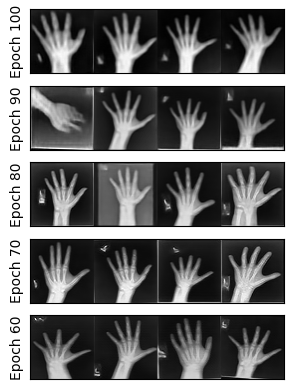

In [22]:
# Plot last 5 evaluations
val_samples = np.linspace(n_epochs, val_interval, int(n_epochs / val_interval))
fig, ax = plt.subplots(nrows=5, ncols=1, sharey=True)
for image_n in range(5):
    reconstructions = torch.reshape(intermediary_images[image_n], (image_size * num_example_images, image_size)).T
    ax[image_n].imshow(reconstructions.cpu(), cmap="gray")
    ax[image_n].set_xticks([])
    ax[image_n].set_yticks([])
    ax[image_n].set_ylabel(f"Epoch {val_samples[image_n]:.0f}")

## Diffusion Model

### Define diffusion model and scheduler

In this section, we will define the diffusion model that will learn data distribution of the latent representation of the autoencoder. Together with the diffusion model, we define a beta scheduler responsible for defining the amount of noise tahat is added across the diffusion's model Markov chain.

In [23]:
unet = DiffusionModelUNet(
    spatial_dims=2,
    in_channels=3,
    out_channels=3,
    num_res_blocks=2,
    num_channels=(128, 256, 512),
    attention_levels=(False, True, True),
    num_head_channels=(0, 256, 512),
)

scheduler = DDPMScheduler(num_train_timesteps=1000, schedule="linear_beta", beta_start=0.0015, beta_end=0.0195)

### Scaling factor

As mentioned in Rombach et al. [1] Section 4.3.2 and D.1, the signal-to-noise ratio (induced by the scale of the latent space) can affect the results obtained with the LDM, if the standard deviation of the latent space distribution drifts too much from that of a Gaussian. For this reason, it is best practice to use a scaling factor to adapt this standard deviation.

_Note: In case where the latent space is close to a Gaussian distribution, the scaling factor will be close to one, and the results will not differ from those obtained when it is not used._


In [24]:
with torch.no_grad():
    with autocast(enabled=True):
        z = autoencoderkl.encode_stage_2_inputs(check_data["image"].to(device))

print(f"Scaling factor set to {1/torch.std(z)}")
scale_factor = 1 / torch.std(z)

Scaling factor set to 0.9202485084533691


<ipython-input-24-91db666bb442>:2: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):


We define the inferer using the scale factor:

In [25]:
inferer = LatentDiffusionInferer(scheduler, scale_factor=scale_factor)

### Train diffusion model

It takes about ~80 min to train the model.

<ipython-input-26-06bccbe7363e>:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 0:   0%|                                | 0/125 [00:00<?, ?it/s]<ipython-input-26-06bccbe7363e>:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):
Epoch 39: 100%|█████████| 125/125 [00:39<00:00,  3.17it/s, loss=0.111]
<ipython-input-26-06bccbe7363e>:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):
<ipython-input-26-06bccbe7363e>:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):


Epoch 39 val loss: 0.1168


100%|██████████| 1000/1000 [00:24<00:00, 41.60it/s]


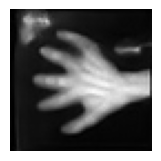

Epoch 40:   0%|                               | 0/125 [00:00<?, ?it/s]<ipython-input-26-06bccbe7363e>:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):
Epoch 77:  49%|████▉     | 61/125 [00:21<00:24,  2.57it/s, loss=0.108]

In [ ]:
optimizer = torch.optim.Adam(unet.parameters(), lr=1e-4)

unet = unet.to(device)
n_epochs = 50
val_interval = 40
epoch_losses = []
val_losses = []
scaler = GradScaler()

for epoch in range(n_epochs):
    unet.train()
    autoencoderkl.eval()
    epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=70)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        images = batch["image"].to(device)
        optimizer.zero_grad(set_to_none=True)
        with autocast(enabled=True):
            z_mu, z_sigma = autoencoderkl.encode(images)
            z = autoencoderkl.sampling(z_mu, z_sigma)
            noise = torch.randn_like(z).to(device)
            timesteps = torch.randint(0, inferer.scheduler.num_train_timesteps, (z.shape[0],), device=z.device).long()
            noise_pred = inferer(
                inputs=images, diffusion_model=unet, noise=noise, timesteps=timesteps, autoencoder_model=autoencoderkl
            )
            loss = F.mse_loss(noise_pred.float(), noise.float())

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()

        progress_bar.set_postfix({"loss": epoch_loss / (step + 1)})
    epoch_losses.append(epoch_loss / (step + 1))

    if (epoch + 1) % val_interval == 0:
        unet.eval()
        val_loss = 0
        with torch.no_grad():
            for val_step, batch in enumerate(val_loader, start=1):
                images = batch["image"].to(device)

                with autocast(enabled=True):
                    z_mu, z_sigma = autoencoderkl.encode(images)
                    z = autoencoderkl.sampling(z_mu, z_sigma)

                    noise = torch.randn_like(z).to(device)
                    timesteps = torch.randint(
                        0, inferer.scheduler.num_train_timesteps, (z.shape[0],), device=z.device
                    ).long()
                    noise_pred = inferer(
                        inputs=images,
                        diffusion_model=unet,
                        noise=noise,
                        timesteps=timesteps,
                        autoencoder_model=autoencoderkl,
                    )

                    loss = F.mse_loss(noise_pred.float(), noise.float())

                val_loss += loss.item()
        val_loss /= val_step
        val_losses.append(val_loss)
        print(f"Epoch {epoch} val loss: {val_loss:.4f}")

        # Sampling image during training
        z = torch.randn((1, 3, 16, 16))
        z = z.to(device)
        scheduler.set_timesteps(num_inference_steps=1000)
        with autocast(enabled=True):
            decoded = inferer.sample(
                input_noise=z, diffusion_model=unet, scheduler=scheduler, autoencoder_model=autoencoderkl
            )

        plt.figure(figsize=(2, 2))
        plt.style.use("default")
        plt.imshow(decoded[0, 0].detach().cpu(), vmin=0, vmax=1, cmap="gray")
        plt.tight_layout()
        plt.axis("off")
        plt.show()
progress_bar.close()


### Plot learning curves

In [ ]:
plt.figure()
plt.title("Learning Curves", fontsize=20)
plt.plot(np.linspace(1, n_epochs, n_epochs), epoch_losses, linewidth=2.0, label="Train")
plt.plot(
    np.linspace(val_interval, n_epochs, int(n_epochs / val_interval)), val_losses, linewidth=2.0, label="Validation"
)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.legend(prop={"size": 14})

### Plotting sampling example

Finally, we generate an image with our LDM. For that, we will initialize a latent representation with just noise. Then, we will use the `unet` to perform 1000 denoising steps. For every 100 steps, we store the noisy intermediary samples. In the last step, we decode all latent representations and plot how the image looks like across the sampling process.

In [ ]:
unet.eval()
scheduler.set_timesteps(num_inference_steps=1000)
noise = torch.randn((1, 3, 16, 16))
noise = noise.to(device)

with torch.no_grad():
    image, intermediates = inferer.sample(
        input_noise=noise,
        diffusion_model=unet,
        scheduler=scheduler,
        save_intermediates=True,
        intermediate_steps=100,
        autoencoder_model=autoencoderkl,
    )

In [ ]:
# Decode latent representation of the intermediary images
decoded_images = []
for image in intermediates:
    with torch.no_grad():
        decoded_images.append(image)
plt.figure(figsize=(10, 12))
chain = torch.cat(decoded_images, dim=-1)
plt.style.use("default")
plt.imshow(chain[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
plt.tight_layout()
plt.axis("off")

In [ ]:
torch.save(unet.state_dict(), '/content/drive/MyDrive/GSET25/hand_moon_unet_model.pth')
torch.save(scheduler.state_dict(), '/content/drive/MyDrive/GSET25/hand_moon_scheduler_model.pth')
torch.save(autoencoderkl.state_dict(), '/content/drive/MyDrive/GSET25/hand_moon_autoencoder_model.pth')

### Clean-up data directory

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)